# Water withdrawals

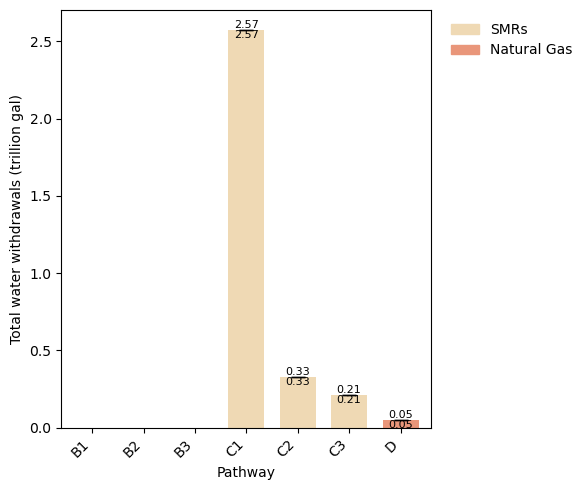

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ── 1) LOAD & FILTER ALL YEARS 2025–2050 ─────────────────────────────────
csv_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/2 Generation Expansion Model/5 Dispatch Curve/4 Final Results/1 Comprehensive Days Summary Results/Yearly_Results.csv"
yr = pd.read_csv(csv_path)
yr = yr[yr['Year'].between(2025, 2050)]

# ── 2) SUM GENERATION BY SIMULATION × PATHWAY (OVER ALL YEARS) ────────────
gen_cols = ['SMR_TWh', 'New_Fossil_Fuel_TWh']
sim_path = (
    yr
    .groupby(['Simulation','Pathway'])[gen_cols]
    .sum()
    .reset_index()
)
sim_path = sim_path[sim_path['Pathway'] != 'A']  # drop A if present
sim_path = sim_path.set_index(['Simulation','Pathway'])

# ── 3) WATER‐USE FACTORS (gal MWh⁻¹ midpoints) ─────────────────────────────
water_mid = {
    'SMR_TWh':             740,               # water-cooled SMRs
    'New_Fossil_Fuel_TWh': np.mean([15,50])   # dry-cooled gas
}

# ── 4) COMPUTE WATER USE PER SIM & PATHWAY ───────────────────────────────
# (TWh)*(gal/MWh) → million gallons
water_mgal = sim_path.mul(pd.Series(water_mid))
water_tr3 = water_mgal / 1e6  # trillion gallons

# ── 5) FOR EACH PATHWAY: MEAN & 10/90th PERCENTILE TOTAL WATER ─────────────
total_by_sim = water_tr3.sum(axis=1)                # (Simulation,Pathway) → total
mean_total   = total_by_sim.groupby('Pathway').mean()
low_total    = total_by_sim.groupby('Pathway').quantile(0.10)
high_total   = total_by_sim.groupby('Pathway').quantile(0.90)

# ── 6) MEAN PER-TECH CONTRIBUTION (unchanged) ─────────────────────────────
mean_tech = water_tr3.groupby('Pathway').mean()

# ── 7) PLOT WITH 10/90 CI ERROR BARS ──────────────────────────────────────
colors     = {"SMR_TWh":"#EFD9B4","New_Fossil_Fuel_TWh":"#E9967A"}
legend_map = {"SMR_TWh":"SMRs","New_Fossil_Fuel_TWh":"Natural Gas"}

ax = mean_tech.plot(
    kind='bar', stacked=True,
    color=[colors[t] for t in mean_tech.columns],
    figsize=(6,5), width=0.7
)
ax.set_xticklabels(mean_tech.index, rotation=45, ha='right')
ax.set_ylabel('Total water withdrawals (trillion gal)')

# prepare non-negative lower/upper errors
err_low_vals  = (mean_total - low_total).abs().values
err_high_vals = (high_total - mean_total).abs().values
yerr          = np.vstack([err_low_vals, err_high_vals])

# mask out B1, B2, B3
mask    = ~mean_total.index.isin(['B1','B2','B3'])
x       = np.arange(len(mean_total))
x_err   = x[mask]
yerr_m  = yerr[:, mask]
mean_m  = mean_total.values[mask]

ax.errorbar(
    x_err, mean_m,
    yerr=yerr_m,
    fmt='none', ecolor='black', capsize=5
)

# annotate the 10th and 90th percentile bounds
for idx in np.where(mask)[0]:
    xi = x[idx]
    lo = low_total.values[idx]
    hi = high_total.values[idx]
    span = hi - lo
    off  = span * 0.1
    ax.text(xi, hi + off, f"{hi:.2f}", ha='center', va='bottom', fontsize=8)
    ax.text(xi, lo - off, f"{lo:.2f}", ha='center', va='top',    fontsize=8)

# custom legend
handles = [
    plt.matplotlib.patches.Patch(color=colors[t], label=legend_map[t])
    for t in mean_tech.columns
]
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02,1), frameon=False)

plt.tight_layout()
plt.savefig('water_withdrawals.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
plt.show()


# ─── build & save water‐use summary table with 10/90% CI ───

# 1) per‐tech 10th/90th percentiles
low_tech  = water_tr3.groupby('Pathway').quantile(0.5)
high_tech = water_tr3.groupby('Pathway').quantile(0.95)

# 2) prepare table rows
tech_map    = {'SMR_TWh':'SMRs', 'New_Fossil_Fuel_TWh':'Natural Gas'}
rows        = list(tech_map.values()) + ['Sum']
water_table = pd.DataFrame(index=rows, columns=mean_tech.index, dtype=object)

# 3) fill each tech row
for col, label in tech_map.items():
    for pw in mean_tech.index:
        m  = mean_tech.at[pw, col]
        lo = low_tech.at[pw, col]
        hi = high_tech.at[pw, col]
        water_table.at[label, pw] = f"{m:.2f} ({lo:.2f}-{hi:.2f})"

# 4) fill the Sum row
for pw in mean_tech.index:
    m  = mean_total.at[pw]
    lo = low_total.at[pw]
    hi = high_total.at[pw]
    water_table.at['Sum', pw] = f"{m:.2f} ({lo:.2f}-{hi:.2f})"

# 5) add Unit column & name index
water_table.index.name = 'Technology'
water_table.insert(0, 'Unit', ['Trillion gallons'] * len(water_table))

# 6) write to Excel
water_table.to_excel(
    'water_withdrawals_summary.xlsx',
    sheet_name='Water withdrawals',
    startrow=1
)
